# Adjusted Cohort Graduation Rate

In [34]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss
import boto3
import shelve
import missingno


In [35]:
def make_raw_gr_frame(year):
    """Create raw graduation rate dataframe for a given year from S3. It is 'raw' because
    no modifications are done and it is cached locally as-is."""
    conn = boto3.client('s3')

    # Graduation rate raw data filenames on S3
    year_to_loc = {2018: "grad_rate/acgr-sch-sy2018-19-wide.csv",
                   2017: "grad_rate/acgr-sch-sy2017-18.csv",
                   2016: "grad_rate/acgr-sch-sy2016-17.csv",
                   2015: "grad_rate/acgr-sch-sy2015-16.csv",
                   2014: "grad_rate/acgr-release2-sch-sy2014-15.csv",
                   2013: "grad_rate/acgr-sch-sy2013-14.csv",
                   2012: "grad_rate/acgr-sch-sy2012-13.csv",
                   2011: "grad_rate/acgr-sch-sy2011-12.csv",
                   2010: "grad_rate/acgr-sch-sy2010-11.csv"}

    # Verify input parameter is valid
    if year not in list(range(2010, 2019)):
        raise ValueError("input parameter {} is out of range.".format(year))

    # Local storage (cache) for the raw data so that iteration time is faster.
    shelf = shelve.open("gr_dfs")

    df = pd.DataFrame()
    shelf_key = str(year)

    if shelf_key in shelf:
        df = shelf[shelf_key]
    else:
        tmp_file_name = 'curr_file.csv.bak'
        conn.download_file('edu-data-bucket', year_to_loc[year], tmp_file_name)

        df = pd.read_csv(tmp_file_name)
        shelf[shelf_key] = df

        if os.path.exists(tmp_file_name):
            os.remove(tmp_file_name)

    # Shelve teardown
    shelf.close()
    return df


def year_string(y: int):
    """Input an integer year and get a range that matches the column suffixes in the raw data.
    e.g. 2011 => 1112 and 2018 => 1819."""
    return str(y)[-2:] + str(int(str(y)[-2:]) + 1)


In [36]:
def make_big_df_of_all_years():
    """ Create one large dataframe by combining several years of Adjusted Cohort graduation rate data."""
    
    dfs = [make_raw_gr_frame(year=y) for y in range(2010, 2019)]
    years = [year_string(y) for y in range(2010, 2019)]
    # Start by removing the years from the column names.
    # cols_wo_year => Column names without the year
    cols_wo_year = [list(map(lambda x: x.replace(y, ""), df.columns))
                    for y, df in zip(years, dfs)]

    # Columns that are common to all years that we want to keep
    cols_to_keep = ['Stnam', 'Fipst', 'Leaid', 'Leanm',
                    'Ncessch', 'Schnam', 'All_Cohort_', 'All_Rate_']

    # Rationale for dropping group subpopulation data, taken from the codebook:
    # Why doesn’t the summation of the major racial and ethnic groups equal the “ALL” student count?
    # * Due to flexibilities with states’ implementation of the Elementary and Secondary Education Act,
    #   there may be instances where not all possible groupings of racial/ethnic identification are reported
    #   as individual subgroups. Therefore, some information may be missing and these counts by major racial
    #   and ethnic group will not include every student; however any students not included within an individual
    #   major racial and ethnic group would be included in the “ALL” student count.
    # #### Why are the major racial and ethnic groups reported differently by states?
    # * Under the ESEA, a State educational agency (SEA) has the flexibility to determine the major racial/ethnic
    #   groups it will use for reporting on the data included in its assessment and accountability system.  The
    #   subgroups that an SEA uses are approved through its Accountability Workbook (the most recent copy of each
    #   state’s workbook can be found here:  http://www2.ed.gov/admins/lead/account/stateplans03/index.html).
    #   As a result, there is some variation in how SEAs report data by race and ethnicity.

    dfs_with_clean_names = []
    for y, df in zip(years, dfs):
        df_names = df.columns.tolist()
        new_names = []
        for name in df_names:
            # Remove the year from the column name
            name = name.replace(y, "")
            # Title case the name
            name = name.title()
            new_names += [name]
        # Rename the dataframe columns
        df.columns = new_names
        df = df[cols_to_keep]
        dfs_with_clean_names += [df]

    del dfs

    big_df = pd.DataFrame()

    for idx, df in enumerate(dfs_with_clean_names):
        col_names = df.columns.tolist()
        df['Year'] = list(range(2010, 2019))[idx]
        # Reorder columns
        df = df[['Year']+col_names]
        big_df = pd.concat([big_df, df], axis=0)

    return big_df

In [37]:
big_df = make_big_df_of_all_years()


In [38]:
# Missingness
big_df.isnull().sum()


# Drop rows where ALL_COHORT_ == '.'
instances_after_drop = len(big_df) - 2913
# Reindex the dataframe because their are duplicate indexes
big_df.index = list(range(len(big_df)))
big_df.drop(big_df[big_df.All_Cohort_ == '.'].index, axis=0, inplace=True)
assert len(big_df) == instances_after_drop
print("Number of instances after this drop", len(big_df))
# Can convert ALL_COHORT_ column to numeric now
big_df.loc[:, 'All_Cohort_'] = np.int64(big_df.All_Cohort_.values)
big_df.dtypes

# Drop rows where ALL_RATE_ == 'PS'. About 1400 schools per year are dropped.
# Approximately 1200 schools per year were dropped that had a cohort size of 5 or less
# because they had no graduation rate.
# Outliers seen during ingestion of the individual Adjusted Cohort Dataset had cohort sizes of 5-30,000 (3 schools).
# These corresponded to one large virtual high school in Ohio and two schools with listed cohort sizes on their website of ~150 (transcription errors).

print("Dropping", len(big_df[big_df.All_Rate_ == 'PS']))
big_df.drop(big_df[big_df.All_Rate_ == 'PS'].index, axis=0, inplace=True)
print("Number of instances after this drop", len(big_df))


Number of instances after this drop 198654
Dropping 12507
Number of instances after this drop 186147


/tmp/ipykernel_206750/3531663573.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:, 'All_Cohort_'] = np.int64(big_df.All_Cohort_.values)


In [39]:
# Convert year feature to numeric
big_df.loc[:, 'Year'] = np.int64(big_df.Year)

# THe All_Rate_ column has numbers given as ranges, numbers with GE,LE,LT,GT prefixes, and also 'PS'.
# The codebook explains that these are to conceal specifics when it would give us the ability to identify individual students. The 'PS' specifically means that the cohort had 5 or fewer students in it.
# Drop the All_Rate_ rows that have 'PS' and convert the rest to the average meaning of the term. E.g. GT50 => 75, LT50 => 25, 88-92 => 90.

# Helper functions to convert ranges given in All_Rate_ column to a trivially convertible string


def conv_range_to_numeric_string(t: str):
    """Take in a numeric range given as a string, e.g. "10-20" and return the midpoint as a string."""
    vals = t.split("-")
    if len(vals) == 2:
        val1, val2 = float(vals[0]), float(vals[1])
        new_val = val1 / 2.0 + val2 / 2.0
        return str(new_val)
    else:
        # If a range with a dash in it is not found, return original string unchanged.
        return t


assert conv_range_to_numeric_string('95-95') == '95.0'
assert conv_range_to_numeric_string('105-110') == '107.5'
assert conv_range_to_numeric_string('90') == '90'


def strip_prefixed_string(t: str):
    """
    Convert prefixed numbers to a string of a number in the midpoint of their range 
    """
    if t.startswith('GT'):
        t = t.removeprefix('GT')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('GE'):
        t = t.removeprefix('GE')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('LT'):
        t = t.removeprefix('LT')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    elif t.startswith('LE'):
        t = t.removeprefix('LE')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    # If one of the prefixes is not found, return original string unchanged
    return t


assert strip_prefixed_string('GE50') == '75.0'
assert strip_prefixed_string('GT50') == '75.0'
assert strip_prefixed_string('LE90') == '45.0'
assert strip_prefixed_string('LT90') == '45.0'
assert strip_prefixed_string('95-95') == '95-95'

# Run the above functions on the series to produce a float64 series
big_df.loc[:, 'All_Rate_'] = big_df.All_Rate_.map(
    strip_prefixed_string, na_action='ignore')
big_df.loc[:, 'All_Rate_'] = big_df.All_Rate_.map(
    conv_range_to_numeric_string, na_action='ignore')
big_df.loc[:, 'All_Rate_'] = pd.to_numeric(big_df.All_Rate_.tolist())

# Schools are found with >20,000 students in a cohort. Based on google search, the graduating classes are closer to 100-200 than the extremely large sizes reported.
# We drop these schools since they are called into question. Note that we could impute them with the mean school size.

large_school_indexes = big_df.All_Cohort_ > 5000
big_df.loc[large_school_indexes, :]
big_df.drop(big_df[large_school_indexes].index, axis=0, inplace=True)

# Rename BUREAU OF INDIAN AFFAIRS to BUREAU OF INDIAN EDUCATION
indian_affairs_rows = big_df.query(
    "Stnam.str.contains('INDIAN AFFAIRS')").index
big_df.loc[indian_affairs_rows, 'Stnam'] = 'BUREAU OF INDIAN EDUCATION'


/tmp/ipykernel_206750/3475107816.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:, 'All_Rate_'] = pd.to_numeric(big_df.All_Rate_.tolist())


In [59]:
big_df.to_csv('grad_rate_intermediate.csv.bak', index=False)
del big_df


NameError: name 'big_df' is not defined

# School Directory Dataset

In [47]:
conn = boto3.client('s3')
local_dir_filename = 'directory_all.csv.bak'
if not os.path.exists('./' + local_dir_filename):
    conn.download_file(
        'edu-data-bucket', 'directory/schools_ccd_directory.csv', local_dir_filename)

df0 = pd.read_csv(local_dir_filename, low_memory=False)

df0.shape


(3381565, 52)

#### There are many years and schools in this dataset that are not in the graduation rate dataset
    * Ncessch and ncessch_num are duplicates
    * Features shared with the Adjusted Cohort dataset are
        * ncessch
        * school_name
        * leaid
        * lea_name
        * state_location
        * fips

In [48]:
df0.head()


,year,ncessch,ncessch_num,school_id,school_name,leaid,lea_name,state_leaid,seasch,street_mailing,city_mailing,state_mailing,zip_mailing,street_location,city_location,state_location,zip_location,phone,fips,latitude,longitude,csa,cbsa,urban_centric_locale,county_code,school_level,school_type,school_status,lowest_grade_offered,highest_grade_offered,bureau_indian_education,title_i_status,title_i_eligible,title_i_schoolwide,charter,magnet,shared_time,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,direct_certification,enrollment,ungrade_cedp,elem_cedp,middle_cedp,high_cedp,lunch_program,congress_district_id,state_leg_district_lower,state_leg_district_upper
0,1986,10000201704,10000201704,1704.0,CHALKVILLE CAMPUS,100002.0,DEPARTMENT OF YOUTH SERVICES,210,0020,NaN,BIRMINGHAM,NaN,35220,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,129.0,0,0,1,1,NaN,NaN,NaN,NaN
1,1986,10000201705,10000201705,1705.0,MT MEIGS CAMPUS,100002.0,DEPARTMENT OF YOUTH SERVICES,210,0030,NaN,MOUNT MEIGS,NaN,36057,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,193.0,0,0,1,1,NaN,NaN,NaN,NaN
2,1986,10000201706,10000201706,1706.0,VACCA CAMPUS,100002.0,DEPARTMENT OF YOUTH SERVICES,210,0040,NaN,BIRMINGHAM,NaN,35206,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,7.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5,NaN,NaN,NaN,NaN,162.0,0,0,1,1,NaN,NaN,NaN,NaN
3,1986,10000500870,10000500870,870.0,ALABAMA AVE MIDDLE SCH,100005.0,ALBERTVILLE CITY BOARD,101,0010,NaN,ALBERTVILLE,NaN,35950,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,845.0,0,0,1,0,NaN,NaN,NaN,NaN
4,1986,10000500871,10000500871,871.0,ALBERTVILLE HIGH SCH,100005.0,ALBERTVILLE CITY BOARD,101,0020,NaN,ALBERTVILLE,NaN,35950,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,NaN,NaN,NaN,1025.0,0,0,0,1,NaN,NaN,NaN,NaN


In [49]:
# Subset to our years of interest
years = list(range(2010, 2019))
our_years = df0.query('year in @years')
pd.set_option('display.max_columns', 99)
our_years.head(n=3)

# Remove uninteresting columns
# Uninteresting because duplicate: 'school_id', 'ncessch_num', 'leaid','lea_name','school_name', 'state_location','fips', 'phone_string'
# Verify ncessch == ncescch_num since we will merge on it later.
# Leave school district identifier for verification that the merge worked later.
our_years.drop(['ncessch_num', 'school_id', 'lea_name', 'state_location', 'fips', 'school_status', 'longitude', 'phone', 'city_location', 'street_location', 'street_mailing', 'state_leaid', 'state_leg_district_lower', 'state_leg_district_upper',
               'congress_district_id', 'csa', 'cbsa', 'direct_certification', 'title_i_schoolwide', 'lunch_program', 'seasch', 'city_mailing', 'state_mailing', 'elem_cedp', 'middle_cedp', 'high_cedp', 'shared_time', 'bureau_indian_education'], axis=1, inplace=True)

# Meaningful Missingness
# Use school directory cookbook to make decisions are removing columns that we are uncertain about.
# Of the schools with missing virtual identifier, we are not able to find any that contain obious names that
# would indicate they are virtual. Knowing that virtual schools are less common than brick and mortal, we
# impute the missingess as a False value in order to retain 20000 instances that would otherwise be dropped.

assert len(our_years.query('virtual < 0 and "Virtual" in school_name')) == 0
assert len(our_years.query('virtual < 0 and "virtual" in school_name')) == 0
assert len(our_years.query(
    'virtual < 0 and "Correspondence" in school_name')) == 0
assert len(our_years.query(
    'virtual < 0 and "correspondence" in school_name')) == 0
assert len(our_years.query('virtual < 0 and "Electronic" in school_name')) == 0
assert len(our_years.query('virtual < 0 and "electronic" in school_name')) == 0
assert len(our_years.query('virtual < 0 and "digital" in school_name')) == 0
assert len(our_years.query('virtual < 0 and "Digital" in school_name')) == 0

# This line saves an additional 20K instances and improves the model predictions by about 0.04 accuracy
our_years.loc[:, 'virtual'] = our_years.virtual.replace(np.nan, 0)
assert our_years.virtual.isnull().sum() == 0

# Missingness

# Impute -1,-2,-3 missing values to nans
# Find strings equal to -1,-2, or -3
special_vals = pd.DataFrame([(our_years.select_dtypes(include=[object]) == "-1").sum(), (our_years.select_dtypes(
    include=[object]) == "-2").sum(), (our_years.select_dtypes(include=[object]) == "-3").sum()])
special_vals.index = ["-1", "-2", "-3"]
special_vals

special_vals = pd.DataFrame([(our_years.select_dtypes(include=[np.number]) == -1).sum(), (our_years.select_dtypes(
    include=[np.number]) == -2).sum(), (our_years.select_dtypes(include=[np.number]) == -3).sum()])
special_vals.index = ["-1", "-2", "-3"]
special_vals

str_cols = our_years.select_dtypes(include=object).columns.tolist()
num_cols = our_years.select_dtypes(include=np.number).columns.tolist()
str_col_special_nans = (our_years[str_cols] ==
                        "-1") | (our_years[str_cols] == "-2")
num_col_special_nans = (our_years[num_cols] < 0)
assert "highest_grade_offered" in num_cols

our_years.loc[:, str_cols] = our_years[str_cols].where(
    ~str_col_special_nans, other=np.nan)
our_years.loc[:, num_cols] = our_years[num_cols].where(
    ~num_col_special_nans, other=np.nan)

our_years.highest_grade_offered.value_counts()
non_high_schools = our_years.query('highest_grade_offered <= 9')
our_years.drop(non_high_schools.index, axis=0, inplace=True)


/tmp/ipykernel_206750/1170389932.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.drop(['ncessch_num', 'school_id', 'lea_name', 'state_location', 'fips', 'school_status', 'longitude', 'phone', 'city_location', 'street_location', 'street_mailing', 'state_leaid', 'state_leg_district_lower', 'state_leg_district_upper',
/tmp/ipykernel_206750/1170389932.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.loc[:, 'virtual'] = our_years.virtual.replace(np.nan, 0)
/tmp/ipykernel_206750/1170389932.py:56: SettingWithCopyWarning: 
A value is trying t

<AxesSubplot: >

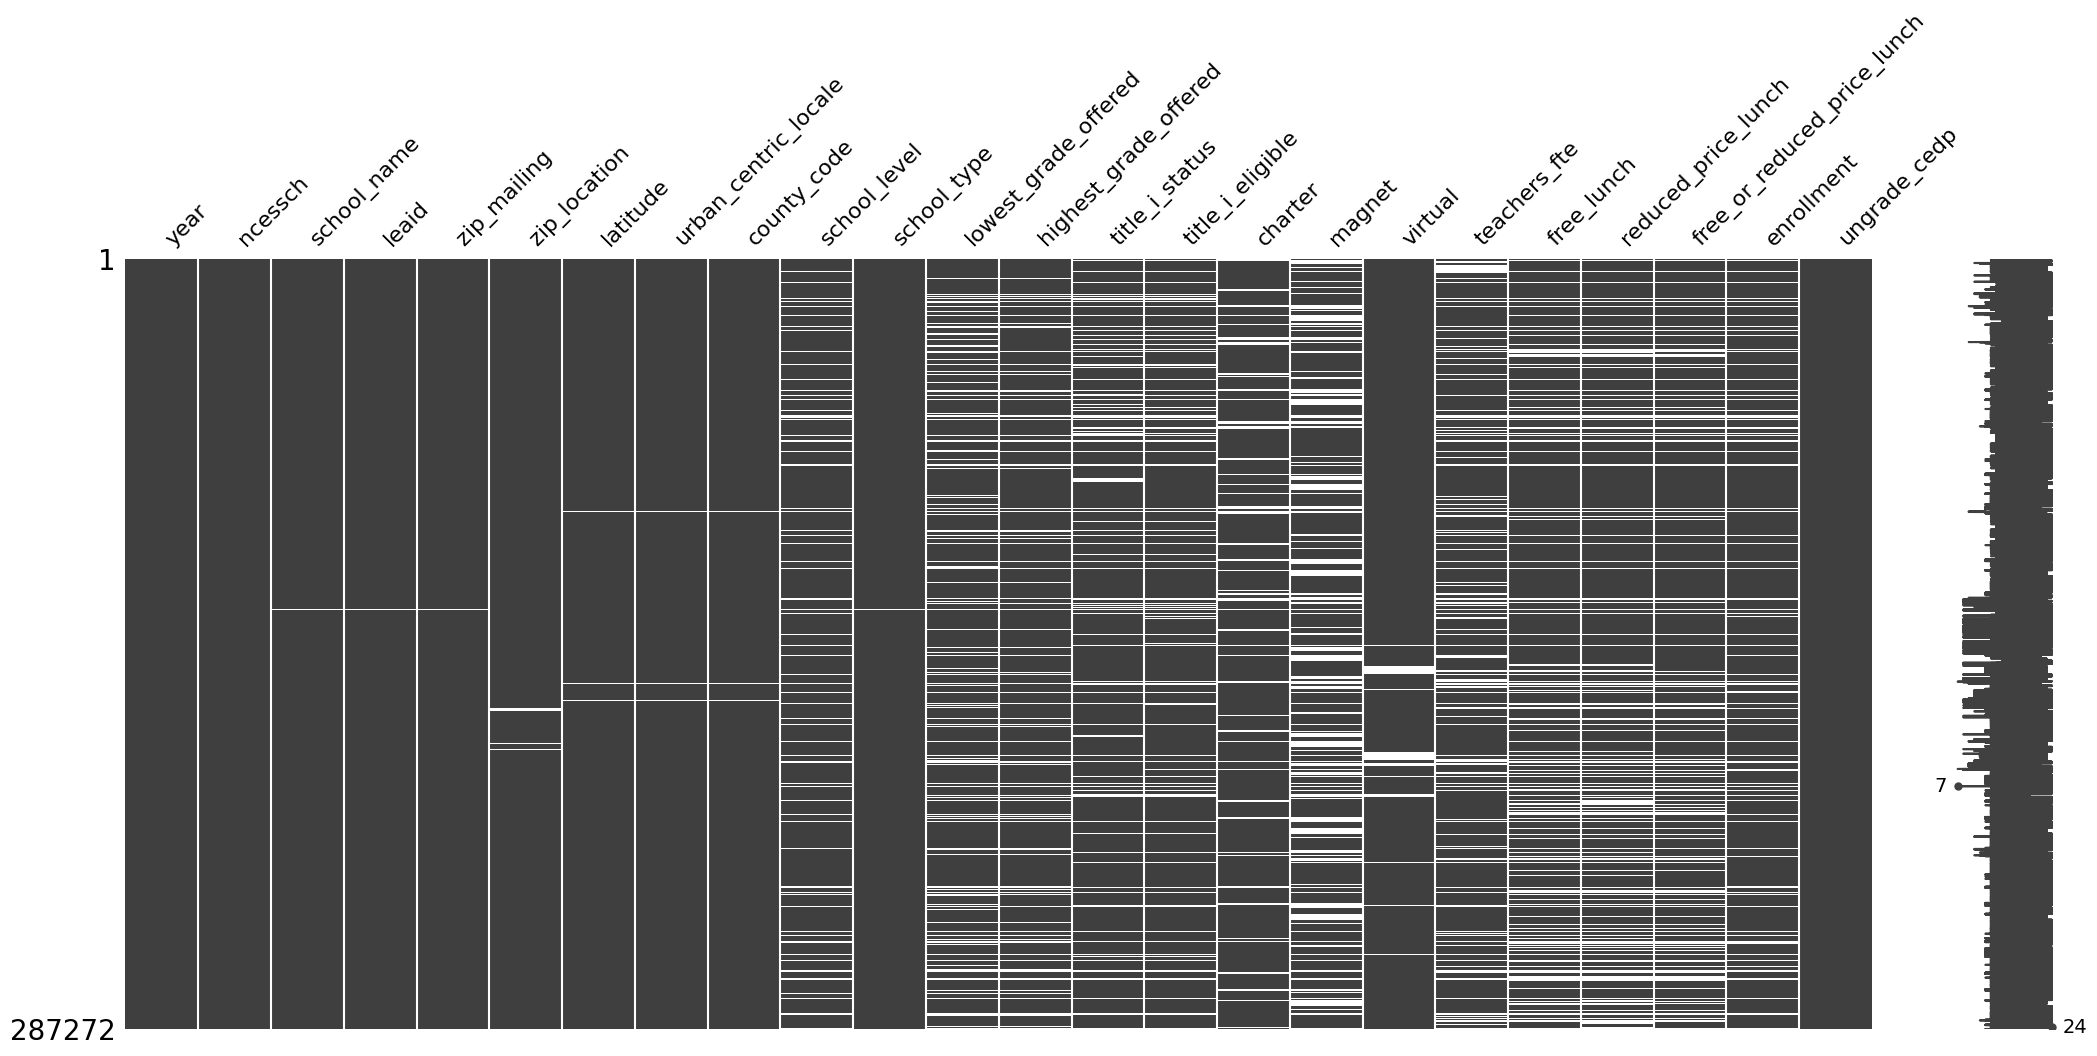

In [50]:
missingno.matrix(our_years)


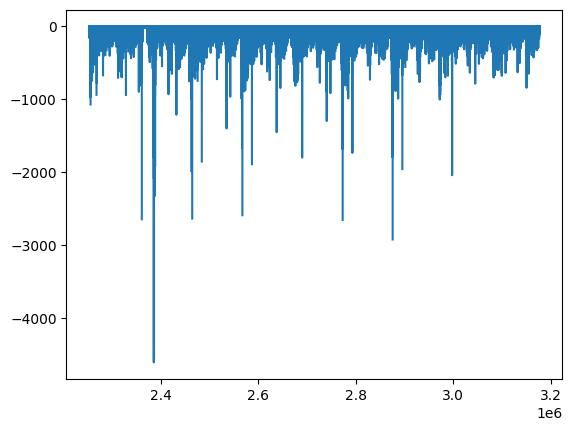

In [51]:
# Examine reduced_price_lunch to see how similar it is to free_or_reduced_price_lunch
plt.plot(np.subtract(our_years.free_lunch,
         our_years.free_or_reduced_price_lunch))
# It looks like there is some additional information in both columns so we'll keep them both.


# Drop all rows with a missing feature, the simplest way to get rid of our nans

In [52]:
instances_before_nan_drop = len(our_years)
our_years.dropna(inplace=True)
instances_after_nan_drop = len(our_years)
our_years = our_years.convert_dtypes(convert_string=False)
print("Number of instances before Nan drop", instances_before_nan_drop)
print("Number of instances after Nan drop", instances_after_nan_drop)


Number of instances before Nan drop 287272
Number of instances after Nan drop 132324


/tmp/ipykernel_206750/3593423663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.dropna(inplace=True)


<AxesSubplot: >

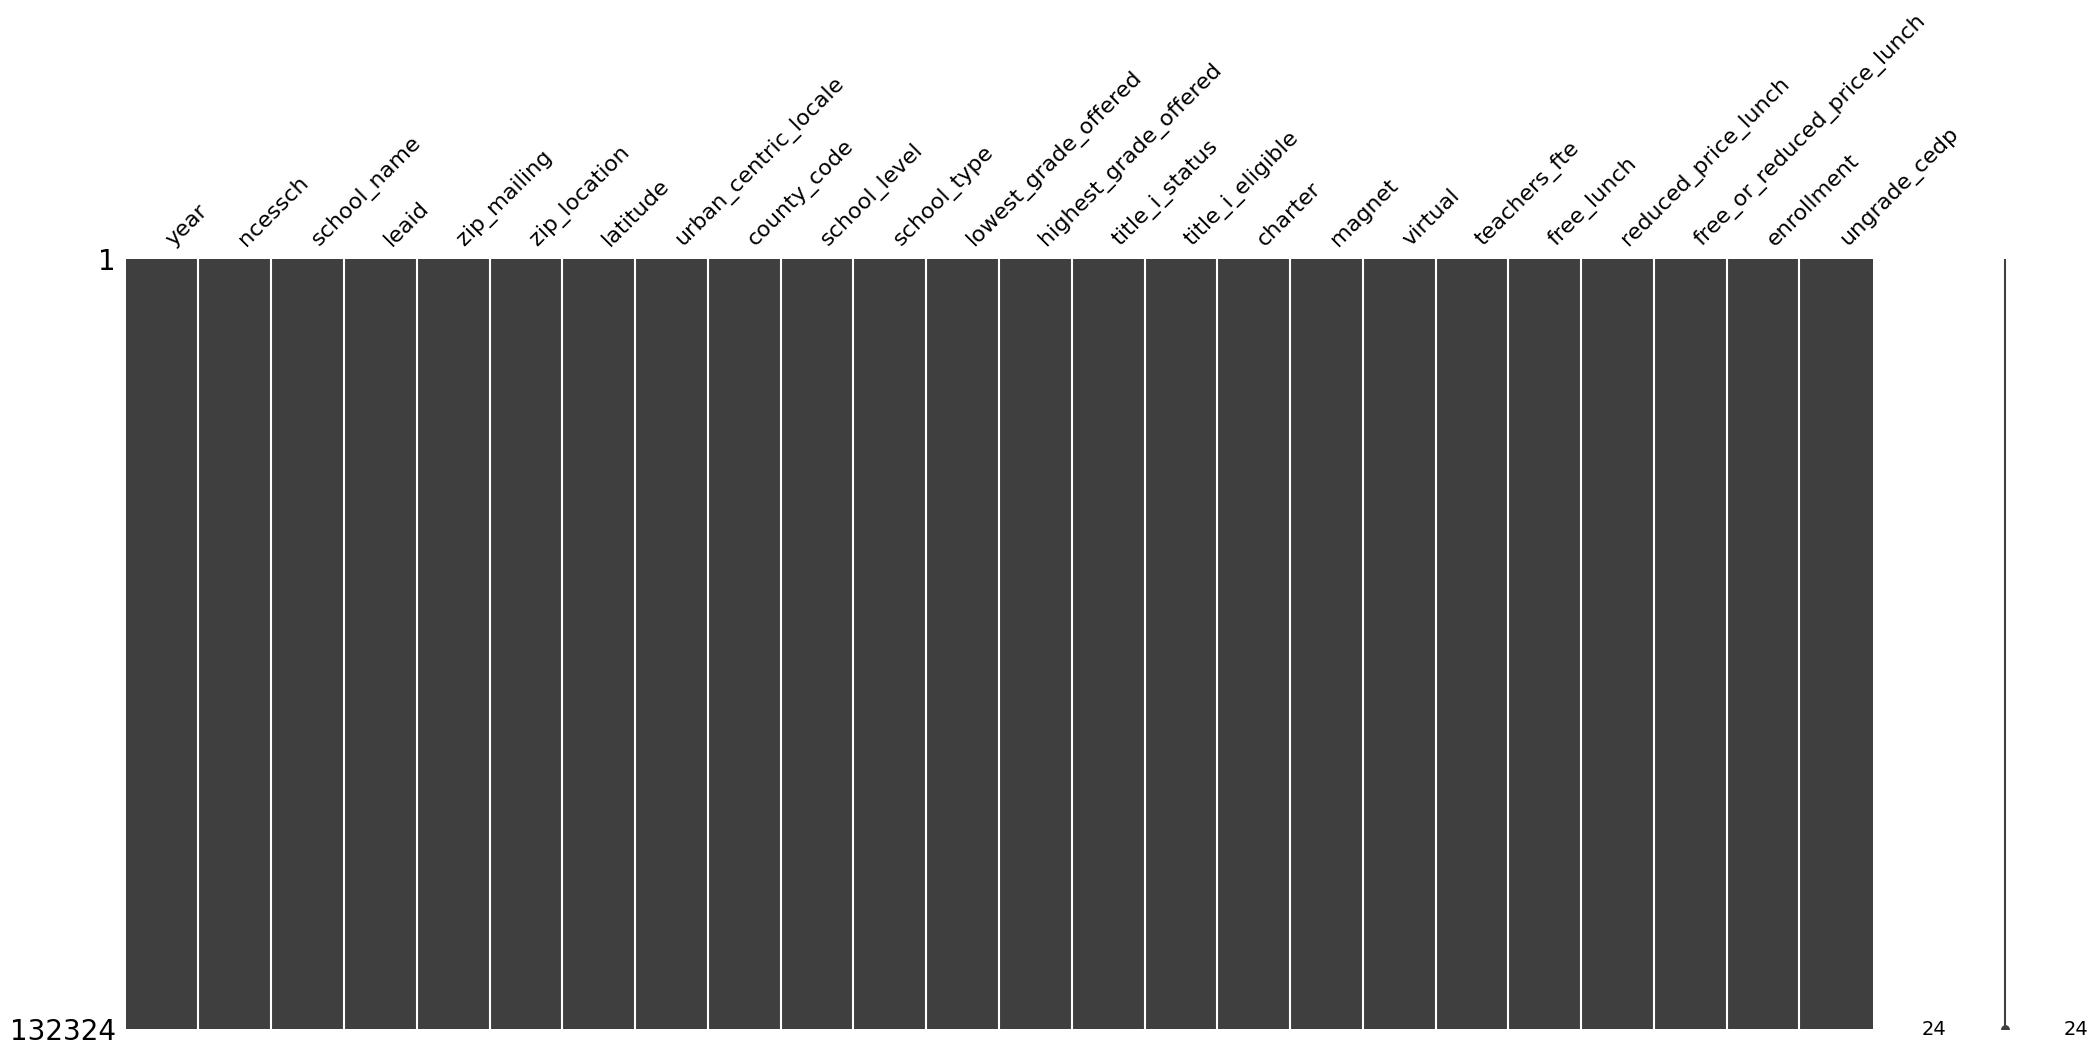

In [53]:
our_years.shape
missingno.matrix(our_years)


# Drop data that is inconsitent with reality or with itself

In [54]:
# Enrollment less than 1 does not make any sense.
# Teachers less than 1 does not make much sense. It is possible that we have part time teachers, but we
# are already dropping schools with less than 5 in their graduating cohort. The decision is made to
# drop schools with less than 1 teacher as well. There is likley significant overlap between these and the
# ALL_COHORT == 'ps' schools.
# @NOTE: The schools definitely warrant further study to help understand what is occuring there.
# There is over evidence below that the Common Core of Data School Directory dataset is a fairly messy dataset.
print(our_years.query('enrollment < 1 or teachers_fte < 1')
      ['county_code'].count())
print(our_years.query('reduced_price_lunch > enrollment')
      ['county_code'].count())
print(our_years.query('free_or_reduced_price_lunch > enrollment')
      ['county_code'].count())

our_years.drop(our_years.query(
    'enrollment < 1 or teachers_fte < 1').index, inplace=True)
our_years.drop(our_years.query(
    'reduced_price_lunch > enrollment').index, inplace=True)
our_years.drop(our_years.query(
    'free_or_reduced_price_lunch > enrollment').index, inplace=True)

print(our_years.query('enrollment < 1 or teachers_fte < 1')
      ['county_code'].count())
print(our_years.query('reduced_price_lunch > enrollment')
      ['county_code'].count())
print(our_years.query('free_or_reduced_price_lunch > enrollment')
      ['county_code'].count())

# A small number of schools have a highest_grade_offered less than 12.
# Looking up several of these schools
# * Hobbs Freshman High School is a 9th grade only school
# * Cyberacademy of South Carolina is K-12
# * With this mixed information, we are opting to drop the rows.
our_years.drop(our_years.query(
    'highest_grade_offered < 12').index, inplace=True)


3195
46
86
0
0
0


# Save pre-cleaned Directory dataset out to intermediate file

In [55]:
our_years.info()
our_years.to_csv('directory_intermediate_dataframe.csv.bak', index=False)
our_years.head(n=3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 126631 entries, 2254443 to 3176836
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         126631 non-null  Int64  
 1   ncessch                      126631 non-null  Int64  
 2   school_name                  126631 non-null  object 
 3   leaid                        126631 non-null  Int64  
 4   zip_mailing                  126631 non-null  object 
 5   zip_location                 126631 non-null  Int64  
 6   latitude                     126631 non-null  Float64
 7   urban_centric_locale         126631 non-null  Int64  
 8   county_code                  126631 non-null  Int64  
 9   school_level                 126631 non-null  Int64  
 10  school_type                  126631 non-null  Int64  
 11  lowest_grade_offered         126631 non-null  Int64  
 12  highest_grade_offered        126631 non-null  Int64

,year,ncessch,school_name,leaid,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp
2254443,2010,20000100208,BETHEL REGIONAL HIGH SCHOOL,200001,99559,99559,60.802525,41,2050,4,1,6,12,3,1,0,0,0,31.5,170,14,184,482,0
2254450,2010,20000100215,ARVIQ SCHOOL,200001,99651,99651,59.0103,43,2050,4,1,0,12,3,1,0,0,0,1.2,9,0,9,12,0
2254451,2010,20000100318,BETHEL ALTERNATIVE BOARDING SCHOOL,200001,99559,99559,60.79596,33,2050,3,4,8,12,3,1,0,0,0,4.0,33,1,34,42,0


# Math and Reading / Language Arts Assessment Participation

In [57]:
# @NOTE: Run the script in the scripts/ directory to produce this file
conn = boto3.client('s3')
remote_filename = 'math_rla_percent_participation_prefiltered.csv'
conn.download_file(
    'edu-data-bucket', 'percent_participation/' + remote_filename, local_dir_filename)

perc_part = pd.read_csv(local_dir_filename, low_memory=False)
perc_part.shape, perc_part.info()

# Drop rows where Math_Pct_Part == 'PS'.
print("Dropping", len(perc_part[perc_part.Math_Pct_Part == 'PS']))
print("Dropping", len(perc_part[perc_part.Rla_Pct_Part == 'PS']))
perc_part.drop(perc_part[perc_part.Math_Pct_Part ==
               '.'].index, axis=0, inplace=True)
perc_part.drop(perc_part[perc_part.Rla_Pct_Part ==
               '.'].index, axis=0, inplace=True)
perc_part.drop(perc_part[perc_part.Math_Pct_Part ==
               'PS'].index, axis=0, inplace=True)
perc_part.drop(perc_part[perc_part.Rla_Pct_Part ==
               'PS'].index, axis=0, inplace=True)

# Run the above functions on the series to produce a float64 series
perc_part.loc[:, 'Math_Pct_Part'] = perc_part.Math_Pct_Part.map(
    strip_prefixed_string, na_action='ignore')
perc_part.loc[:, 'Math_Pct_Part'] = perc_part.Math_Pct_Part.map(
    conv_range_to_numeric_string, na_action='ignore')
perc_part.loc[:, 'Math_Pct_Part'] = pd.to_numeric(
    perc_part.Math_Pct_Part.tolist())

perc_part.loc[:, 'Rla_Pct_Part'] = perc_part.Rla_Pct_Part.map(
    strip_prefixed_string, na_action='ignore')
perc_part.loc[:, 'Rla_Pct_Part'] = perc_part.Rla_Pct_Part.map(
    conv_range_to_numeric_string, na_action='ignore')
perc_part.loc[:, 'Rla_Pct_Part'] = pd.to_numeric(
    perc_part.Rla_Pct_Part.tolist())


# Save intermediate file locally
perc_part.to_csv("percent_participation_intermediate.csv.bak", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160367 entries, 0 to 160366
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Year           160367 non-null  int64 
 1   NCESSCH        160367 non-null  int64 
 2   Math_Pct_Part  160367 non-null  object
 3   Rla_Pct_Part   160367 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB
Dropping 11476
Dropping 10948


/tmp/ipykernel_206750/3361176458.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perc_part.loc[:, 'Math_Pct_Part'] = pd.to_numeric(
/tmp/ipykernel_206750/3361176458.py:34: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perc_part.loc[:, 'Rla_Pct_Part'] = pd.to_numeric(


# Merge first 3 datasets (Adjusted Cohort, Directory, Math and Language Assessment Participation) 

In [58]:
"""
Merge intermediate dataframes 
"""
gr = pd.read_csv('grad_rate_intermediate.csv.bak')
directory = pd.read_csv('directory_intermediate_dataframe.csv.bak')
perc_part = pd.read_csv('percent_participation_intermediate.csv.bak')


merge0 = gr.merge(directory, how='left', left_on=(
    'Year', 'Ncessch'), right_on=('year', 'ncessch'))
merge1 = merge0.merge(perc_part, how='left', left_on=(
    'Year', 'Ncessch'), right_on=('Year', 'NCESSCH'))
merge1.head()

# Drop redundant columns seen after merging
merge1.drop(['year', 'ncessch', 'leaid'], axis=1, inplace=True)

# Drop rows that are NA in the merged dataset
merge1.dropna(inplace=True)
merge1.shape

# Reorder columns
merge1 = merge1[[
    i for i in merge1.columns if i not in 'All_Rate_'] + ['All_Rate_']]


<AxesSubplot:>

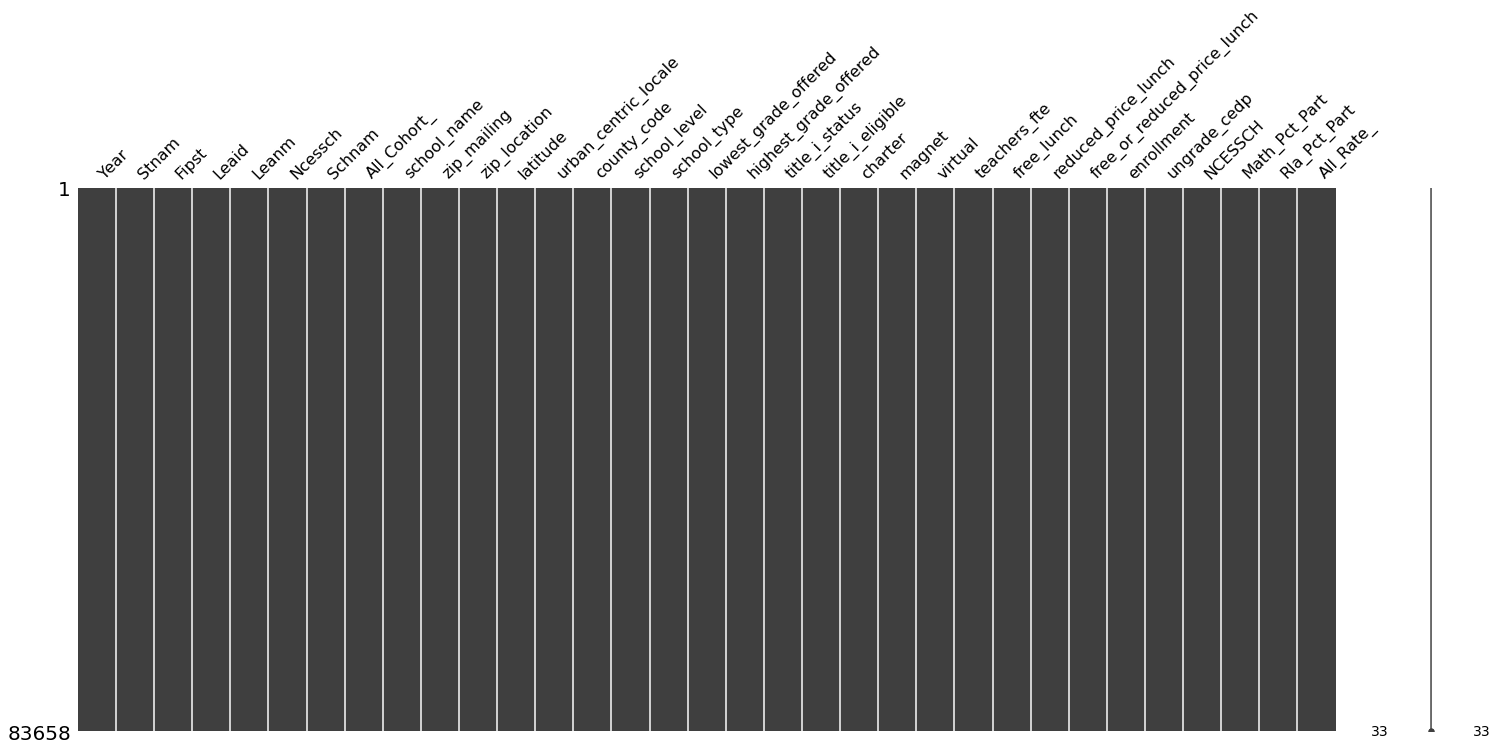

In [32]:
# Show the dataframe after 3 datasets have been merged
missingno.matrix(merge1)


# County unemployment rates from USDA 

In [62]:
# We are adding in this data to attempt to capture whatever underlying factors county_code and state ID's were
# being selecting for in the first round of modeling.
# This way, the model is not predicting performance from past years, and also is not predicting a certain fate based on the county
# or state ID itself.
# Source: https://www.ers.usda.gov/data-products/county-level-data-sets/
conn = boto3.client('s3')
local_filename = 'Unemployment_Median_Income.xlsx.bak'
conn.download_file(
    'edu-data-bucket', 'county_data_from_usda/Unemployment_Median_Income.xlsx', local_filename)

county_raw = pd.read_excel(
    local_filename, header=4)
# Un-needed columns at end of the frame
county_raw.drop(['Median_Household_Income_2020',
                'Med_HH_Income_Percent_of_State_Total_2020'], axis=1, inplace=True)


In [63]:
pd.set_option("display.max_columns", 990)
county_raw.tail(n=3)


,FIPS_code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,Unemployment_rate_2008,Civilian_labor_force_2009,Employed_2009,Unemployed_2009,Unemployment_rate_2009,Civilian_labor_force_2010,Employed_2010,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021
3274,72149,PR,"Villalba Municipio, PR",2.0,2.0,1.0,7636.0,6648.0,988.0,12.9,7564.0,6546.0,1018.0,13.5,8100.0,6820.0,1280.0,15.8,8393.0,7134.0,1259.0,15.0,8622.0,7522.0,1100.0,12.8,9506.0,8112.0,1394.0,14.7,9681.0,8417.0,1264.0,13.1,9479.0,8223.0,1256.0,13.3,9324.0,8036.0,1288.0,13.8,9518.0,7628.0,1890.0,19.9,8841.0,6892.0,1949.0,22.0,8485.0,6681.0,1804.0,21.3,8308.0,6584.0,1724.0,20.8,8184.0,6416.0,1768.0,21.6,7920.0,6196.0,1724.0,21.8,7802.0,6262.0,1540.0,19.7,7815.0,6235.0,1580.0,20.2,7557.0,6090.0,1467.0,19.4,7335.0,6174.0,1161.0,15.8,7494.0,6309.0,1185.0,15.8,NaN,NaN,NaN,NaN,7700.0,6807.0,893.0,11.6
3275,72151,PR,"Yabucoa Municipio, PR",1.0,1.0,1.0,10613.0,9005.0,1608.0,15.2,10751.0,8746.0,2005.0,18.6,11187.0,8961.0,2226.0,19.9,11393.0,9162.0,2231.0,19.6,11170.0,9244.0,1926.0,17.2,11247.0,9272.0,1975.0,17.6,11562.0,9647.0,1915.0,16.6,11425.0,9348.0,2077.0,18.2,10904.0,8931.0,1973.0,18.1,10816.0,8302.0,2514.0,23.2,11003.0,8210.0,2793.0,25.4,10630.0,7924.0,2706.0,25.5,10302.0,7903.0,2399.0,23.3,10169.0,7742.0,2427.0,23.9,9642.0,7546.0,2096.0,21.7,9198.0,7593.0,1605.0,17.4,9081.0,7545.0,1536.0,16.9,9000.0,7512.0,1488.0,16.5,8791.0,7534.0,1257.0,14.3,8841.0,7686.0,1155.0,13.1,NaN,NaN,NaN,NaN,9164.0,8217.0,947.0,10.3
3276,72153,PR,"Yauco Municipio, PR",2.0,2.0,1.0,14664.0,12871.0,1793.0,12.2,14416.0,12475.0,1941.0,13.5,15116.0,13006.0,2110.0,14.0,15161.0,12974.0,2187.0,14.4,15446.0,13493.0,1953.0,12.6,16695.0,14380.0,2315.0,13.9,16747.0,14658.0,2089.0,12.5,16635.0,14451.0,2184.0,13.1,16555.0,14394.0,2161.0,13.1,15826.0,13318.0,2508.0,15.8,12098.0,9514.0,2584.0,21.4,11760.0,9263.0,2497.0,21.2,11531.0,9140.0,2391.0,20.7,11350.0,8959.0,2391.0,21.1,11031.0,8665.0,2366.0,21.4,10748.0,8717.0,2031.0,18.9,10735.0,8719.0,2016.0,18.8,10160.0,8409.0,1751.0,17.2,9748.0,8315.0,1433.0,14.7,9851.0,8409.0,1442.0,14.6,NaN,NaN,NaN,NaN,10213.0,9014.0,1199.0,11.7


# Reshape the county excel file, which has all the years on the same row

In [64]:
county_reshaped = pd.DataFrame(columns=['year', 'county_code', 'area_name', 'rural_urban_continuum_code',
                               'urban_influence_code', 'metro_or_not', 'civilian_labor_force', 'unemployment_rate'])
for (row_id, series) in county_raw.iterrows():
    county_code = series[0]
    area_name = series[2]
    rural_urban_continuum_code = series[3]
    urban_influence_code = series[4]
    metro_or_not = series[5]
    years = list(range(2000, 2022))
    id_starts = list(range(6, len(county_raw.columns), 4))
    for idx, year in enumerate(years):
        civilian_labor_force = series[id_starts[idx]]
        unemployment_rate = series[id_starts[idx]+3]
        if year < 2010 or year > 2018:
            continue
        county_reshaped.loc[len(
            county_reshaped.index)] = year, county_code, area_name, rural_urban_continuum_code, urban_influence_code, metro_or_not, civilian_labor_force, unemployment_rate
        # print(year, civilian_labor_force,unemployment_rate)
        # Tail and head of the dataset show that these fields are being pulled correctly


In [65]:
merge2 = merge1.merge(county_reshaped, how='left', left_on=[
                      'Year', 'county_code'], right_on=['year', 'county_code'])
assert merge2.Year.equals(merge2.year)
merge2.isnull().sum()


Year                           0
Stnam                          0
Fipst                          0
Leaid                          0
Leanm                          0
Ncessch                        0
Schnam                         0
All_Cohort_                    0
school_name                    0
zip_mailing                    0
zip_location                   0
latitude                       0
urban_centric_locale           0
county_code                    0
school_level                   0
school_type                    0
lowest_grade_offered           0
highest_grade_offered          0
title_i_status                 0
title_i_eligible               0
charter                        0
magnet                         0
virtual                        0
teachers_fte                   0
free_lunch                     0
reduced_price_lunch            0
free_or_reduced_price_lunch    0
enrollment                     0
ungrade_cedp                   0
NCESSCH                        0
Math_Pct_P

# Sanity checks on the dataset

In [66]:
# Visually validate that the school district names appear to match the area names for the counties.
# These are from two different datasets so we are making sure the two are self-consitent.
print(merge2[['Leanm', 'area_name']])

assert pd.Series.all(merge2.year == merge2.Year)
assert pd.Series.all(merge2.Ncessch == merge2.NCESSCH)

# Drop some duplicates
merge2.drop(['year', 'NCESSCH', 'area_name'], axis=1, inplace=True)


                                      Leanm                       area_name
0           Lower Kuskokwim School District          Bethel Census Area, AK
1           Lower Kuskokwim School District          Bethel Census Area, AK
2        Mount Edgecumbe High School Agency          Sitka Borough/city, AK
3       Bristol Bay Borough School District         Bristol Bay Borough, AK
4              Cordova City School District  Valdez-Cordova Census Area, AK
...                                     ...                             ...
83653  Sweetwater County School District #2           Sweetwater County, WY
83654       Teton County School District #1                Teton County, WY
83655       Teton County School District #1                Teton County, WY
83656      Weston County School District #7               Weston County, WY
83657    Washakie County School District #1             Washakie County, WY

[83658 rows x 2 columns]


In [67]:
# View column pairs with minimal positive correlation or above
pd.DataFrame((np.abs(merge2.corr()) > 0.3).sum()).T

# All_Rate_ is correlated (positively or negatively) with 4 columns without having one-hotted the categorical variables


/tmp/ipykernel_206750/3872963915.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame((np.abs(merge2.corr()) > 0.3).sum()).T


,Year,Fipst,Leaid,Ncessch,All_Cohort_,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,All_Rate_,rural_urban_continuum_code,urban_influence_code,metro_or_not,civilian_labor_force,unemployment_rate
0,2,6,6,6,11,6,6,2,10,6,2,5,3,2,2,2,1,1,1,11,8,6,7,10,2,4,4,4,8,8,7,4,2


# Title case the column names

In [68]:
new_names = []
for col in merge2.columns:
    if col.endswith("_"):
        col = col[:-1]
    col = col.title()
    new_names += [col]
merge2.columns = new_names


# Rename All_Rate to Grad_Rate and make it the last column

In [69]:
# Reorder the columns so that All_Rate is called Grad_Rate and is last
merge2.rename({'All_Rate': 'Grad_Rate'}, axis=1, inplace=True)

# Reorder columns
merge2 = merge2[[
    i for i in merge2.columns if i not in 'Grad_Rate'] + ['Grad_Rate']]


<AxesSubplot: >

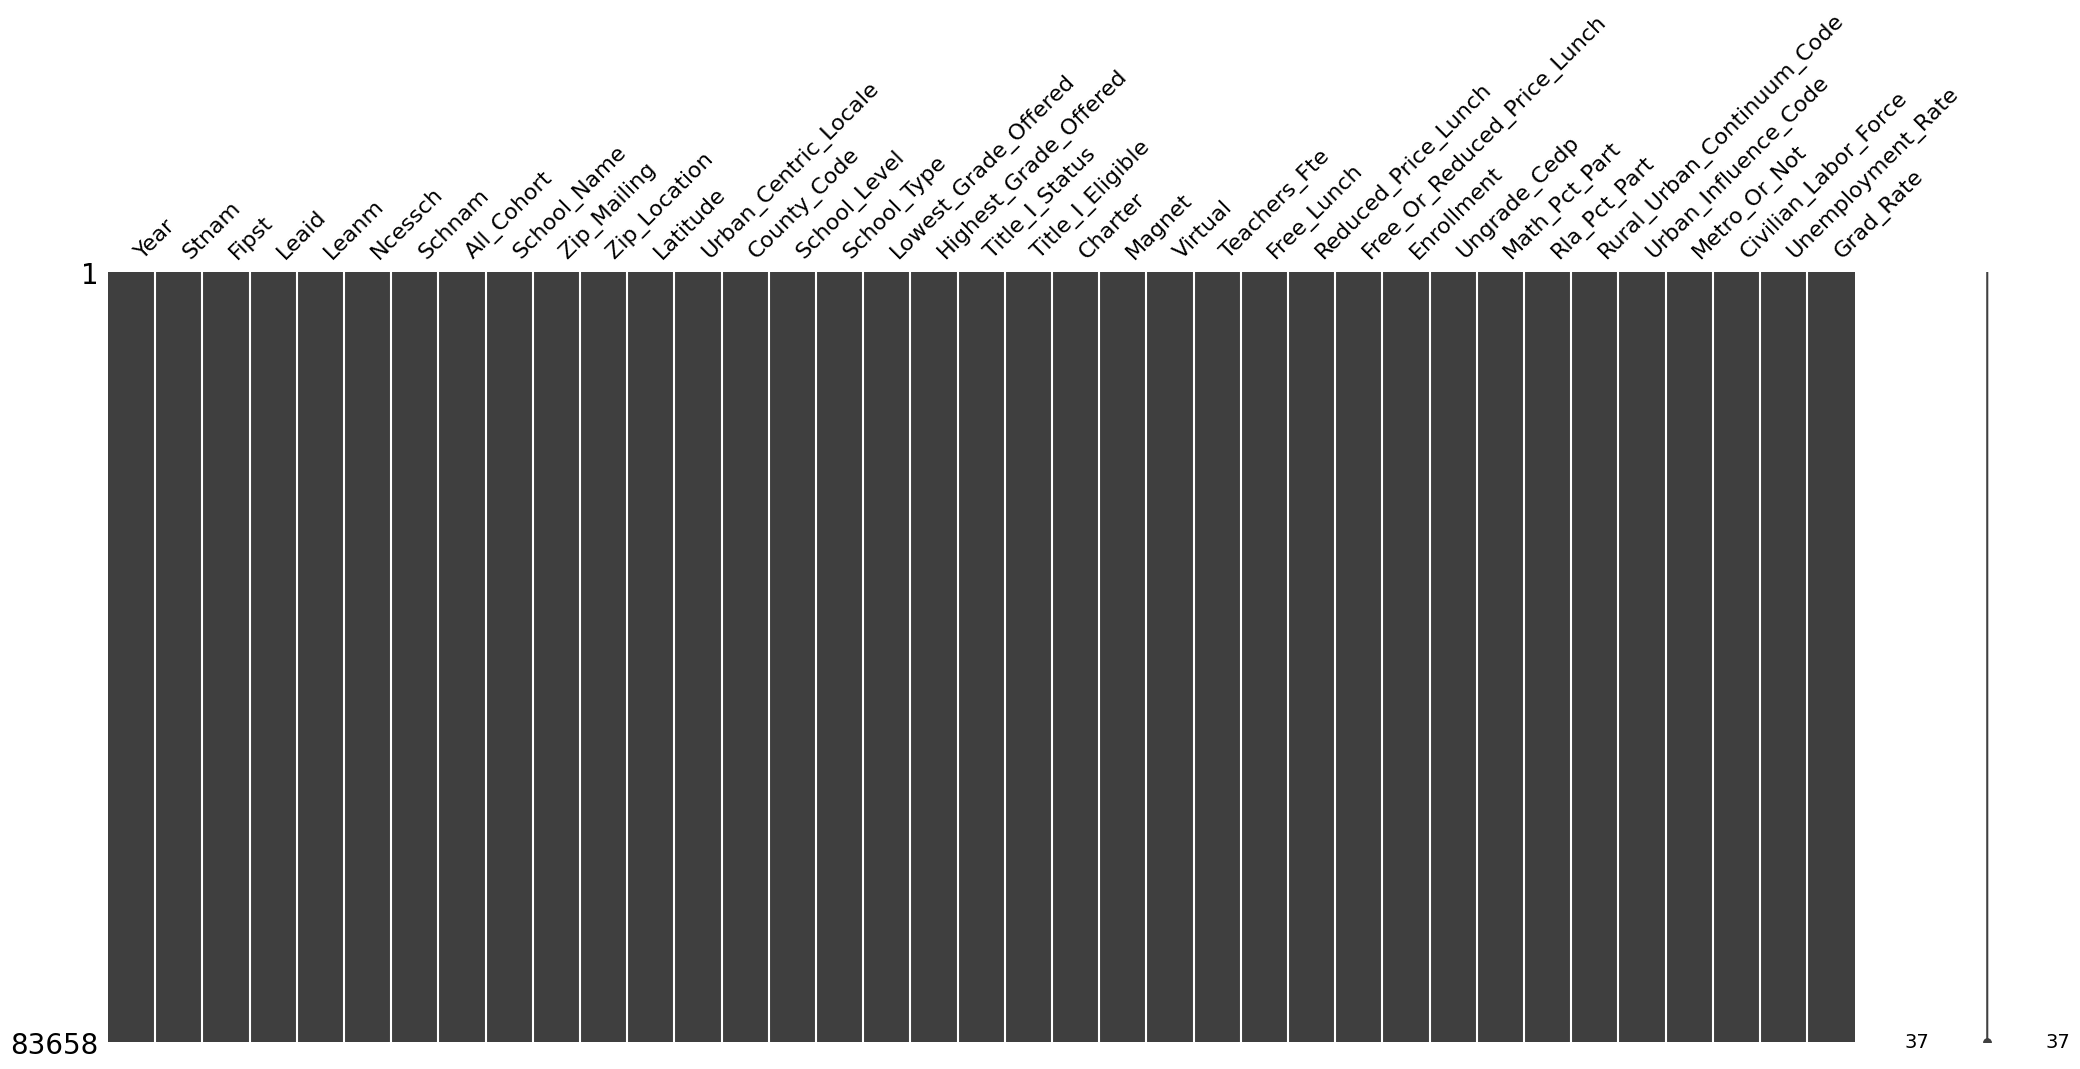

In [70]:
missingno.matrix(merge2)


# Save pre-cleaned dataset to disk

In [71]:
merge2.to_csv('../data/dataset_from_ingestion.csv', index=False)
